In [161]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [162]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df = df.copy()
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def transform_series(df, use_boxcox=True):
    """
    Applies Box-Cox (optional) and StandardScaler to the 'load' column.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'load' column.
        use_boxcox (bool): Whether to apply Box-Cox transform before scaling.

    Returns:
        Tuple[pd.DataFrame, dict]: Transformed DataFrame, and scalers dict with Box-Cox lambda and StandardScaler.
    """
    df = df.copy()
    scalers = {}

    series = df['load'].values
    scalers['load'] = {}

    if use_boxcox:
        series, lam = boxcox(series)
        scalers['load']['lambda'] = lam

    scaler = StandardScaler()
    df['load'] = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    scalers['load']['scaler'] = scaler

    return df, scalers

def apply_transformation(df, scalers, use_boxcox=True):
    """
    Applies previously fitted Box-Cox and StandardScaler to 'load' column in a new DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with 'load' column to transform.
        scalers (dict): Dictionary with 'lambda' and 'scaler' from transform_series.
        use_boxcox (bool): Should match the flag used during training.

    Returns:
        pd.DataFrame: Transformed DataFrame.
    """
    df = df.copy()
    series = df['load'].values

    if use_boxcox:
        lam = scalers['load']['lambda']
        series = boxcox(series, lmbda=lam)

    scaler = scalers['load']['scaler']
    df['load'] = scaler.transform(series.reshape(-1, 1)).flatten()


    return df


def inverse_transform(series, scaler, boxcox_lambda=None):
    """
    Inverts StandardScaler (and Box-Cox if lambda is provided) on a 2D series.

    Parameters:
        series (ndarray): Shape [n_samples, horizon]
        scaler (StandardScaler): fitted scaler object
        boxcox_lambda (float or None): lambda used in boxcox (optional)

    Returns:
        ndarray: Series restored to original scale
    """
    # Step 1: inverse standard scaling
    reshaped = series.reshape(-1, 1)
    unscaled = scaler.inverse_transform(reshaped).reshape(series.shape)

    # Step 2: inverse box-cox if needed
    if boxcox_lambda is not None:
        unscaled = inv_boxcox(unscaled, boxcox_lambda)

    return unscaled


def split_train_test(df, train_frac=0.7, val_frac=0.15):
    """
    Splits the DataFrame into train, validation, and test sets by index (time-based).

    Parameters:
        df (pd.DataFrame): The full dataset.
        train_frac (float): Fraction of data to use for training.
        val_frac (float): Fraction of data to use for validation.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: (train_df, val_df, test_df)
    """
    n = len(df)
    train_end = int(n * train_frac)
    val_end = train_end + int(n * val_frac)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df

In [163]:
def add_time_features(df, interval_minutes=5):
    """
    Adds sin_time and cos_time features based on the time of day, assuming a fixed interval in minutes.

    Parameters:
        df (pd.DataFrame): DataFrame with a datetime index.
        interval_minutes (int): Time interval between observations in minutes (default is 5).

    Returns:
        pd.DataFrame: DataFrame with 'sin_time' and 'cos_time' columns added.
    """
    df = df.copy()

    minutes_in_day = 24 * 60
    steps_per_day = minutes_in_day // interval_minutes

    time_of_day = (df.index.hour * 60 + df.index.minute) / interval_minutes
    angle = 2 * np.pi * time_of_day / steps_per_day

    df['sin_time'] = np.sin(angle)
    df['cos_time'] = np.cos(angle)

    return df


def create_sliding_windows(df, lookback, horizon):
    X, y = [], []
    data = df[['load', 'sin_time', 'cos_time']].values

    for i in range(len(data) - lookback - horizon + 1):
        x_window = data[i:i+lookback]
        y_window = data[i+lookback:i+lookback+horizon, 0]  # only 'load' as target

        X.append(x_window)
        y.append(y_window)

    X = np.array(X)  # shape: [num_samples, lookback, features]
    y = np.array(y)  # shape: [num_samples, horizon]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def create_sliding_windows_with_end_times(df, lookback, horizon):
    X, y, end_times = [], [], []
    data = df[['load', 'sin_time', 'cos_time']].values
    times = df.index  # assumes your index is timestamp
    for i in range(len(data) - lookback - horizon + 1):
        x_window = data[i:i+lookback]
        y_window = data[i+lookback:i+lookback+horizon, 0]
        end_time = str(times[i + lookback - 1])  # convert to string here!
        X.append(x_window)
        y.append(y_window)
        end_times.append(end_time)
    X = np.array(X)
    y = np.array(y)
    end_times = np.array(end_times)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), end_times

def get_future_time_features(batch_end_times, horizon, interval_minutes=5):
    batch_size = len(batch_end_times)
    future_sin = np.zeros((batch_size, horizon, 1), dtype=np.float32)
    future_cos = np.zeros((batch_size, horizon, 1), dtype=np.float32)
    for i, ts in enumerate(batch_end_times):
        fut_times = pd.date_range(ts + pd.Timedelta(minutes=interval_minutes), periods=horizon, freq=f'{interval_minutes}min')
        minutes_in_day = 24 * 60
        steps_per_day = minutes_in_day // interval_minutes
        time_of_day = (fut_times.hour * 60 + fut_times.minute) / interval_minutes
        angle = 2 * np.pi * time_of_day / steps_per_day
        future_sin[i, :, 0] = np.sin(angle)
        future_cos[i, :, 0] = np.cos(angle)
    return future_sin, future_cos

class WindowedDataset(Dataset):
    def __init__(self, X, y, end_times):
        self.X = X
        self.y = y
        self.end_times = end_times

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.end_times[idx]

In [164]:
def compute_forecast_metrics(y_true, y_pred):
    """
    Computes MAE and MAPE per forecast horizon and returns a DataFrame summary.

    Parameters:
        y_true (Tensor or ndarray): Shape [num_samples, horizon]
        y_pred (Tensor or ndarray): Same shape as y_true

    Returns:
        pd.DataFrame: DataFrame with MAE, MAPE per horizon, and overall metrics
    """
    if hasattr(y_true, 'detach'):  # torch.Tensor
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    horizon = y_true.shape[1]
    rows = []

    for i in range(horizon):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])
        rows.append({'horizon': i + 1, 'MAE': mae, 'MAPE': mape})

    df = pd.DataFrame(rows)
    overall = pd.DataFrame([{
        'horizon': 'overall',
        'MAE': df['MAE'].mean(),
        'MAPE': df['MAPE'].mean()
    }])

    return pd.concat([df, overall], ignore_index=True)


def plot_test_vs_pred_time(test_df, y_true_inv, y_pred_inv, horizons=None, title="Forecast vs Actual"):
    """
    Plots actual and predicted values over time for selected forecast horizons.

    Parameters:
        test_df (pd.DataFrame): Original test DataFrame with DateTime index
        y_true_inv (ndarray): [num_samples, horizon] inverse-transformed true values
        y_pred_inv (ndarray): same shape
        horizons (int or list[int] or None):
            - int: plot only that horizon (1-based index)
            - list[int]: plot each selected horizon separately
            - None: plot all horizons
        title (str): Plot title
    """
    if hasattr(y_true_inv, "detach"): y_true_inv = y_true_inv.detach().cpu().numpy()
    if hasattr(y_pred_inv, "detach"): y_pred_inv = y_pred_inv.detach().cpu().numpy()

    num_samples, max_h = y_true_inv.shape

    # Normalize horizons input to 0-based list
    if horizons is None:
        selected_horizons = list(range(max_h))
    elif isinstance(horizons, int):
        selected_horizons = [horizons - 1]
    else:
        selected_horizons = [h - 1 for h in horizons]

    for h in selected_horizons:
        # Align timestamp index to each horizon
        aligned_index = test_df.index[-(num_samples + h):-h or None]

        # Ensure the slice fits
        if len(aligned_index) != num_samples:
            raise ValueError(f"Mismatch for horizon {h+1}: {len(aligned_index)} timestamps vs {num_samples} predictions")

        plt.figure(figsize=(12, 4))
        plt.plot(aligned_index, y_true_inv[:, h], label='Actual', linewidth=2)
        plt.plot(aligned_index, y_pred_inv[:, h], label='Predicted', linewidth=2, linestyle='--')
        plt.title(f"{title} (Horizon {h + 1})")
        plt.xlabel("Time")
        plt.ylabel("Load")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [165]:
class Seq2SeqForecast(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=2, horizon=6, lstm_dropout=0.1, final_dropout=0.1):
        super().__init__()
        self.horizon = horizon
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        self.decoder = nn.LSTM(3, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        self.dropout = nn.Dropout(final_dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, future_sin, future_cos):

        _, (h_n, c_n) = self.encoder(x)
        outputs = []

        decoder_input = x[:, -1:, :]

        for t in range(self.horizon):
            out, (h_n, c_n) = self.decoder(decoder_input, (h_n, c_n))
            out = self.dropout(out)
            pred_load = self.fc(out)  # [batch, 1, 1]
            outputs.append(pred_load)

            if t+1 < self.horizon:
                next_sin = future_sin[:, t:t+1, :]  # [batch, 1, 1]
                next_cos = future_cos[:, t:t+1, :]  # [batch, 1, 1]
                decoder_input = torch.cat([pred_load, next_sin, next_cos], dim=2)  # [batch, 1, 3]

        return torch.cat(outputs, dim=1)



In [166]:
x = torch.randn(5, 10, 3)  # [batch_size, lookback, features]
model = Seq2SeqForecast(input_size=3, hidden_size=32, output_size=6, num_layers=1, lstm_dropout=0.1, final_dropout=0.1)
model(x)

TypeError: Seq2SeqForecast.__init__() got an unexpected keyword argument 'output_size'

In [140]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, interval_minutes=5):
    model.to(device)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        for inputs, targets, end_times in tqdm(train_loader, leave=False, desc="Train", dynamic_ncols=True):
            inputs, targets = inputs.to(device), targets.to(device)
            # Generate future features for this batch
            batch_end_times = pd.to_datetime(end_times)
            future_sin, future_cos = get_future_time_features(batch_end_times, model.horizon, interval_minutes)
            future_sin = torch.tensor(future_sin, dtype=torch.float32, device=inputs.device)
            future_cos = torch.tensor(future_cos, dtype=torch.float32, device=inputs.device)
            optimizer.zero_grad()
            outputs = model(inputs, future_sin, future_cos)
            loss = criterion(outputs.squeeze(-1), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_preds.append(outputs.squeeze(-1).detach().cpu())
            train_targets.append(targets.cpu())
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        # Metrics
        train_mae = np.mean(np.abs(train_targets - train_preds))
        train_mape = np.mean(np.abs((train_targets - train_preds) / (train_targets + 1e-8)))
        # --- Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for inputs, targets, end_times in tqdm(val_loader, leave=False, desc="Val", dynamic_ncols=True):
                inputs, targets = inputs.to(device), targets.to(device)
                batch_end_times = pd.to_datetime(end_times)
                future_sin, future_cos = get_future_time_features(batch_end_times, model.horizon, interval_minutes)
                future_sin = torch.tensor(future_sin, dtype=torch.float32, device=inputs.device)
                future_cos = torch.tensor(future_cos, dtype=torch.float32, device=inputs.device)
                outputs = model(inputs, future_sin, future_cos)
                loss = criterion(outputs.squeeze(-1), targets)
                val_loss += loss.item() * inputs.size(0)
                val_preds.append(outputs.squeeze(-1).cpu())
                val_targets.append(targets.cpu())
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        val_mae = np.mean(np.abs(val_targets - val_preds))
        val_mape = np.mean(np.abs((val_targets - val_preds) / (val_targets + 1e-8)))
        print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        print(f"Train MAE: {train_mae:.4f} | MAPE: {train_mape:.2%} | Val MAE: {val_mae:.4f} | MAPE: {val_mape:.2%}")


def evaluate_model(model, data_loader, device, interval_minutes=5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, end_times in tqdm(data_loader, leave=False, desc="Eval", dynamic_ncols=True):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_end_times = pd.to_datetime(end_times)
            future_sin, future_cos = get_future_time_features(batch_end_times, model.horizon, interval_minutes)
            future_sin = torch.tensor(future_sin, dtype=torch.float32, device=inputs.device)
            future_cos = torch.tensor(future_cos, dtype=torch.float32, device=inputs.device)
            outputs = model(inputs, future_sin, future_cos)
            all_preds.append(outputs.squeeze(-1).cpu())
            all_targets.append(targets.cpu())

    y_pred = torch.cat(all_preds, dim=0).numpy()   # shape: [n_samples, horizon]
    y_true = torch.cat(all_targets, dim=0).numpy()
    return y_true, y_pred

In [174]:
lookback = 64
input_size = 3
hidden_size = 256
horizon = 24
num_layers = 4
lstm_dropout = 0.1
final_dropout = 0.1
lr = 1e-3
num_epochs = 20
interval_minutes = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [175]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df).iloc[1:]
if 'load_diff' in df.columns:
    df = df.drop(columns=['load_diff'])
df = add_time_features(df)
train_df, val_df, test_df = split_train_test(df, train_frac=0.7, val_frac=0.15)
train_df_t, scalers = transform_series(train_df, use_boxcox=True)
val_df_t = apply_transformation(val_df, scalers, use_boxcox=True)
test_df_t = apply_transformation(test_df, scalers, use_boxcox=True)

X_train, y_train, end_times_train = create_sliding_windows_with_end_times(train_df_t, lookback, horizon)
X_val, y_val, end_times_val = create_sliding_windows_with_end_times(val_df_t, lookback, horizon)
X_test, y_test, end_times_test = create_sliding_windows_with_end_times(test_df_t, lookback, horizon)

train_dataset = WindowedDataset(X_train, y_train, end_times_train)
val_dataset = WindowedDataset(X_val, y_val, end_times_val)
test_dataset = WindowedDataset(X_test, y_test, end_times_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [176]:
model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    horizon=horizon,
    lstm_dropout=lstm_dropout,
    final_dropout=final_dropout,
)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [177]:
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, interval_minutes=interval_minutes)

Epoch 1/20


Train Loss: 0.299939 | Val Loss: 0.224168
Train MAE: 0.2999 | MAPE: 149.21% | Val MAE: 0.2242 | MAPE: 45.84%
Epoch 2/20


Train Loss: 0.120663 | Val Loss: 0.125209
Train MAE: 0.1207 | MAPE: 54.04% | Val MAE: 0.1252 | MAPE: 36.66%
Epoch 3/20


Train Loss: 0.105698 | Val Loss: 0.098263
Train MAE: 0.1057 | MAPE: 44.82% | Val MAE: 0.0983 | MAPE: 38.92%
Epoch 4/20


Train Loss: 0.096403 | Val Loss: 0.098461
Train MAE: 0.0964 | MAPE: 39.50% | Val MAE: 0.0985 | MAPE: 35.93%
Epoch 5/20


Train Loss: 0.094188 | Val Loss: 0.127145
Train MAE: 0.0942 | MAPE: 38.20% | Val MAE: 0.1271 | MAPE: 40.90%
Epoch 6/20


Train Loss: 0.092221 | Val Loss: 0.151078
Train MAE: 0.0922 | MAPE: 37.56% | Val MAE: 0.1511 | MAPE: 44.28%
Epoch 7/20


Train Loss: 0.087343 | Val Loss: 0.115033
Train MAE: 0.0873 | MAPE: 36.37% | Val MAE: 0.1150 | MAPE: 38.42%
Epoch 8/20


Train Loss: 0.089080 | Val Loss: 0.119541
Train MAE: 0.0891 | MAPE: 35.66% | Val MAE: 0.1195 | MAPE: 41.74%
Epoch 9/20


Train Loss: 0.083854 | Val Loss: 0.117017
Train MAE: 0.0839 | MAPE: 33.30% | Val MAE: 0.1170 | MAPE: 43.42%
Epoch 10/20


Train Loss: 0.081084 | Val Loss: 0.141373
Train MAE: 0.0811 | MAPE: 34.35% | Val MAE: 0.1414 | MAPE: 42.60%
Epoch 11/20


Train Loss: 0.081184 | Val Loss: 0.099149
Train MAE: 0.0812 | MAPE: 34.13% | Val MAE: 0.0991 | MAPE: 34.67%
Epoch 12/20


Train Loss: 0.084506 | Val Loss: 0.121240
Train MAE: 0.0845 | MAPE: 33.77% | Val MAE: 0.1212 | MAPE: 41.85%
Epoch 13/20


Train Loss: 0.083205 | Val Loss: 0.110617
Train MAE: 0.0832 | MAPE: 32.70% | Val MAE: 0.1106 | MAPE: 41.51%
Epoch 14/20


Train Loss: 0.084204 | Val Loss: 0.104704
Train MAE: 0.0842 | MAPE: 33.72% | Val MAE: 0.1047 | MAPE: 40.36%
Epoch 15/20


Train Loss: 0.073414 | Val Loss: 0.108222
Train MAE: 0.0734 | MAPE: 29.80% | Val MAE: 0.1082 | MAPE: 32.37%
Epoch 16/20


Train Loss: 0.072935 | Val Loss: 0.108671
Train MAE: 0.0729 | MAPE: 30.93% | Val MAE: 0.1087 | MAPE: 39.78%
Epoch 17/20


Train Loss: 0.072473 | Val Loss: 0.113170
Train MAE: 0.0725 | MAPE: 29.77% | Val MAE: 0.1132 | MAPE: 35.47%
Epoch 18/20


Train Loss: 0.068624 | Val Loss: 0.093976
Train MAE: 0.0686 | MAPE: 29.49% | Val MAE: 0.0940 | MAPE: 27.57%
Epoch 19/20


Train Loss: 0.069828 | Val Loss: 0.116812
Train MAE: 0.0698 | MAPE: 28.90% | Val MAE: 0.1168 | MAPE: 41.59%
Epoch 20/20


Train Loss: 0.072576 | Val Loss: 0.114103
Train MAE: 0.0726 | MAPE: 31.31% | Val MAE: 0.1141 | MAPE: 34.67%


In [178]:
y_true, y_pred = evaluate_model(model, test_loader, device)
results = compute_forecast_metrics(y_true, y_pred)
results

,horizon,MAE,MAPE
0,1,0.179841,0.122380
1,2,0.182795,0.134289
2,3,0.188124,0.148930
3,4,0.195661,0.165753
4,5,0.203332,0.177970
5,6,0.210818,0.198258
6,7,0.218149,0.218950
7,8,0.225417,0.235666
8,9,0.232900,0.257764
9,10,0.240864,0.285217


In [179]:
y_true_inv = inverse_transform(y_true, scalers['load']['scaler'], scalers['load'].get('lambda'))
y_pred_inv = inverse_transform(y_pred, scalers['load']['scaler'], scalers['load'].get('lambda'))
metrics_df = compute_forecast_metrics(y_true_inv, y_pred_inv)
metrics_df

,horizon,MAE,MAPE
0,1,1503.144532,0.014779
1,2,1528.624124,0.015184
2,3,1573.486042,0.015676
3,4,1636.905146,0.016367
4,5,1701.490332,0.017076
5,6,1764.574095,0.017781
6,7,1826.416588,0.018483
7,8,1887.764938,0.019185
8,9,1950.985508,0.019918
9,10,2018.313883,0.020706


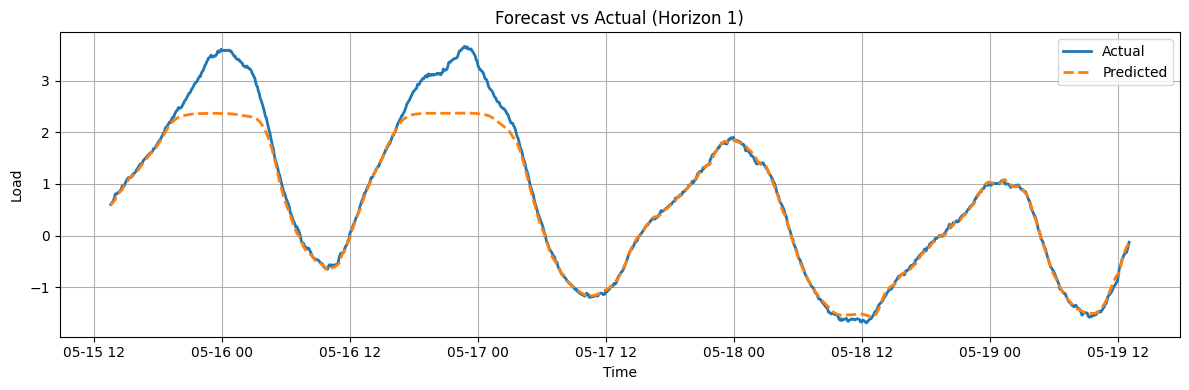

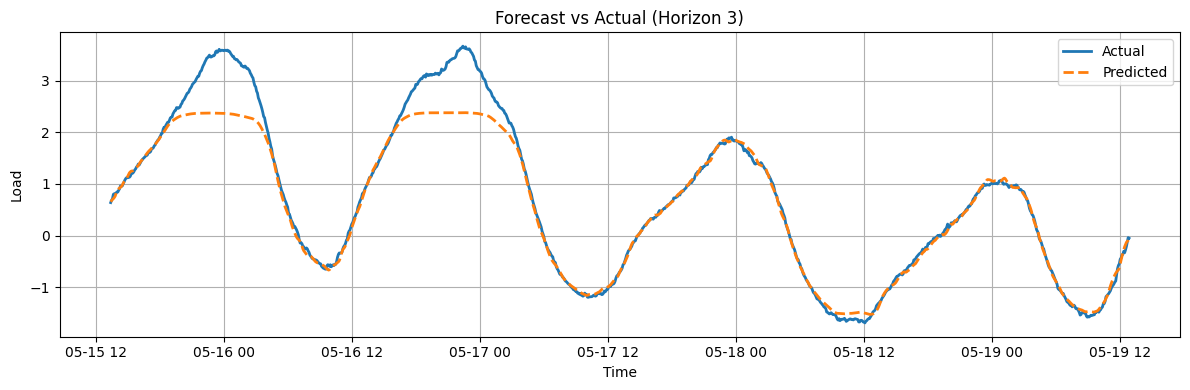

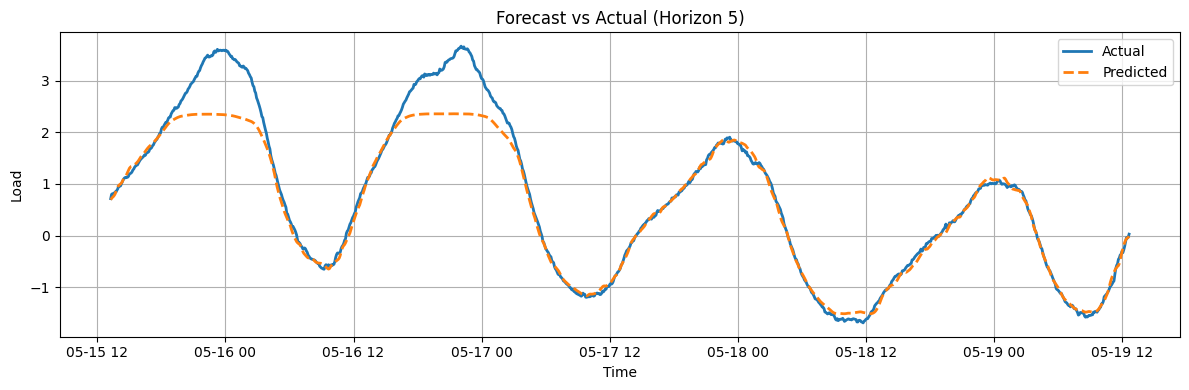

In [181]:
plot_test_vs_pred_time(test_df, y_true, y_pred, horizons=[1, 3, 5])